# HW 6: Character Classification using CNNs with PyTorch

*Jinyi Zhou | u1424752 | July 16*

In this assignment we'll tackle a slightly more complicated image classification problem than MNIST digit classification. We're going to classify characters that contain (gasp!) letters!

The dataset we'll play with is from University of California, Irvine (UCI) and contains a bunch of images of letters of various fonts. Some printed + scanned, some the values screen-capped from a computer. The images are 20x20 pixels, grayscale.

In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Step 1: Data Acquisition + Cleanup

Grab the dataset and unzip it.

The unzipped folder contains a CSV file for each of the various fonts in the data set. Pick one to work with and load it into a pandas dataframe.

In [127]:
sitka = pd.read_csv('fonts/SITKA.csv')
sitka.head()

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,SITKA,SITKA TEXT,64260,0.4,0,0.0,50,22,47,68,...,255,255,143,1,1,233,255,255,255,233
1,SITKA,SITKA TEXT,64259,0.4,0,0.0,50,22,47,69,...,255,251,101,1,48,242,255,255,255,233
2,SITKA,SITKA TEXT,64258,0.4,0,0.0,50,22,47,43,...,1,1,197,255,255,255,255,255,255,220
3,SITKA,SITKA TEXT,64257,0.4,0,0.0,50,22,47,44,...,1,40,228,255,255,255,255,255,255,221
4,SITKA,SITKA TEXT,64256,0.4,0,0.0,50,22,47,50,...,138,255,255,255,255,255,233,44,1,1


Unfortunately the data is in a really, really horrible format for us. We're going to throw away basically everything except for the ``m_label`` field (the unicode codepoint for the character, which is the ascii value for basic alphanumeric characters) and the pixel values which are scattered across 400 columns labeled rxcy (where x and y are the row and column numbers that range from 0 to 19).

Now, write a function that takes in one of these types of dataframe and returns 2 numpy arrays: Xs which is a ``#samples x 20 x 20`` array containing the pixel values, and Ys which is a ``#samples x 1`` array containing the ASCII value for each character. You should normalize the Xs array so the values go from 0-1 (most likely this requires dividing by 255).

For our labels, we'll need to do a little bit of preprocessing as well. While we COULD use the ascii/unicode values of the characters as our label, this wouldn't work very well because we'd basically need to have outputs from 0 up to the max number, even though a lot of those won't have corresponding characters in the dataset. This is especially true for fonts that have high unicode code-point characters in them. To make our lives easier, we'll want to assign each character a smaller index value. I suggest making dictionaries to convert from unicode number to label index and vice versa, which will be basically the same as we did for words in the NLP with Neural Nets code.

In [128]:
df = sitka.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)
d = df.loc[:, df.columns != 'm_label']
reshaped = d.to_numpy().reshape(-1, 20, 20)

reshaped = reshaped.astype('float64')
reshaped *= (1.0/reshaped.max())
y = df.loc[:, df.columns == 'm_label'].to_numpy()
y_unq = np.unique(y)

labels = {}
for i in range(len(y_unq)):
    labels[i] = y_unq[i]

def get_key(val, d): 
    for key, value in d.items(): 
         if val == value: 
             return key 
         
y_labels = []            
for i in range(0, len(y), 1):
    y_labels.append(get_key(y[i], labels))

## Step 2: Build a PyTorch Network

We're going to use the PyTorch library, like we've seen in class, to build/train our network. Check out the notebooks we've made in class or the official documentation/tutorials.

To start with, we're going to use a model very similar to the MNIST CNN we used in class. It will consist of:

- a Convolution2D layer with ReLU activations
- a max pooling layer
- another convolution layer
- another max pooling layer
- a dense layer with relu activation
- a dense layer

Compile and train your network like we did in class. You'll probably have to use the ``np.reshape()`` function on your data to make PyTorch happy. I reshaped my X values like ``np.reshape(Xs, (-1, 1, 20, 20))`` to get them in the right format.

In [129]:
X_train, X_test, y_train, y_test = train_test_split(reshaped, y_labels, random_state=1, test_size=0.3)  

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        c1Out = 32
        c2Out = 32
        self.conv1 = nn.Conv2d(1, c1Out, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(c1Out, c2Out, 5)
        self.pooledOutputSize = c2Out * 2 * 2
        self.fc1 = nn.Linear(self.pooledOutputSize, 3200)
        self.fc2 = nn.Linear(3200, len(y_unq))


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()

In [130]:
xy_train = []
for i in range(0, len(X_train), 1):
    xy_train.append((X_train[i], y_train[i]))
    
xy_test = []
for i in range(0, len(X_test), 1):
    xy_test.append((X_test[i], y_test[i]))

For training, you'll want to check out torch.utils.data.DataLoader which can take a TensorDataset so you can iterate over batches like we did in class for the MNIST data.

In [131]:
def train(model, epochs, data):
    print('Training...')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    trainloader = torch.utils.data.DataLoader(data, batch_size=8, shuffle=True, num_workers=0)

    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.reshape((-1, 1, 20, 20))
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Training finished.')

## Step 3: Exploration and Evaluation

- Evaluate the network using cross validation (splitting data into training/testing). What is its accuracy?
- Create and train a different network topology (add more convolution layers, experiment with normalization (batch normalization or dropout), explore other types/sizes of layer). Try to find a topology that works better than the one described above. 

In [132]:
def evaluate(model, data):
    testloader = torch.utils.data.DataLoader(data, batch_size=8,shuffle=True, num_workers=0)
    correct = 0
    total = 0
    to_return = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.reshape((-1, 1, 20, 20))
            outputs = model(images.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            bools = predicted == labels
            for i in range(len(bools)):
                if bools[i] == False:
                    to_return.append(predicted[i].item())
    print('Network accuracy on test images: %d %%' % (100 * correct / total))
    return to_return

In [133]:
train(net, 4, xy_train)

Training...
Training finished.


In [134]:
out = evaluate(net, xy_test)

Network accuracy on test images: 73 %


- Test the accuracy of your network with character inputs from a DIFFERENT font set. How does it perform?

In [135]:
vin = pd.read_csv('fonts/VIN.csv')
vin.head()

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,VIN,scanned,49,0.4,0,0.0,0,0,61,5,...,215,215,194,194,194,194,101,101,101,101
1,VIN,scanned,78,0.4,0,0.0,0,0,63,20,...,30,30,33,52,99,171,212,222,207,156
2,VIN,scanned,65,0.4,0,0.0,0,0,58,19,...,3,4,5,8,20,50,98,157,205,204
3,VIN,scanned,65,0.4,0,0.0,0,0,61,22,...,28,28,31,42,72,121,167,186,174,132
4,VIN,scanned,50,0.4,0,0.0,0,0,65,23,...,196,200,202,204,202,193,168,122,73,39


In [136]:
df_vin = vin.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)
d_vin = df_vin.loc[:, df_vin.columns != 'm_label']
reshaped_vin = d_vin.to_numpy().reshape(-1, 20, 20)
reshaped_vin = reshaped_vin.astype('float64')
reshaped_vin *= (1.0 / reshaped_vin.max())

y_vin = df_vin.loc[:, df_vin.columns == 'm_label'].to_numpy()

y_unq_vin = np.unique(y_vin)

labels_vin = {}
for i in range(len(y_unq_vin)):
    labels_vin[i] = y_unq_vin[i]

y_labels_vin = []            
for i in range(0, len(y_vin), 1):
    y_labels_vin.append(get_key(y_vin[i], labels_vin))

In [137]:
X_train_vin, X_test_vin, y_train_vin, y_test_vin = train_test_split(reshaped_vin, y_labels_vin, random_state=1, test_size=0.3)  

In [138]:
xy_train_vin = []
for i in range(0, len(X_train_vin), 1):
    xy_train_vin.append((X_train_vin[i], y_train_vin[i]))
    
xy_test_vin = []
for i in range(0, len(X_test_vin), 1):
    xy_test_vin.append((X_test_vin[i], y_test_vin[i]))

In [139]:
train(net, 4, xy_train_vin)

Training...
Training finished.


In [140]:
eval_vin = evaluate(net, xy_test_vin)

Network accuracy on test images: 95 %


*Vin performs better than Sitka.*

- Train your best network on inputs from the data from at least 2 different fonts. How does your accuracy compare to the 1-font case?

In [141]:
two_fonts = pd.concat([sitka, vin], axis=0)
# two_fonts.head()
two_fonts.tail()

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
1000,VIN,scanned,49,0.4,0,0.0,0,0,59,4,...,203,203,203,203,203,194,194,194,194,194
1001,VIN,scanned,68,0.4,0,0.0,0,0,66,21,...,193,155,108,67,35,15,5,3,4,4
1002,VIN,scanned,52,0.4,0,0.0,0,0,32,17,...,106,157,195,199,155,106,66,39,25,22
1003,VIN,scanned,55,0.4,0,0.0,0,0,63,18,...,162,117,71,41,28,25,24,24,24,25
1004,VIN,scanned,68,0.4,0,0.0,0,0,63,20,...,226,191,153,111,70,37,20,14,12,11


In [142]:
df2 = two_fonts.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)
d2 = df2.loc[:, df2.columns != 'm_label']
reshaped2 = d2.to_numpy().reshape(-1,20,20)

reshaped2 = reshaped2.astype('float64')
reshaped2 *= (1.0 / reshaped2.max())

y2 = df2.loc[:, df2.columns == 'm_label'].to_numpy()

y_unq2 = np.unique(y2)

labels2 = {}
for i in range(len(y_unq2)):
    labels2[i] = y_unq2[i]

y_labels2 = []            
for i in range(0, len(y2), 1):
    y_labels2.append(get_key(y2[i], labels2))

In [143]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(reshaped2, y_labels2, random_state=1, test_size=0.3)

xy_train2 = []
for i in range(0, len(X_train2), 1):
    xy_train2.append((X_train2[i], y_train2[i]))
    
xy_test2 = []
for i in range(0, len(X_test2), 1):
    xy_test2.append((X_test2[i], y_test2[i]))

In [144]:
train(net, 4, xy_train2)

Training...
Training finished.


In [145]:
eval_twoFonts = evaluate(net, xy_test2)

Network accuracy on test images: 79 %


In [146]:
if eval_twoFonts > out:
    print('two-font case performs better than Sitka alone')
elif eval_twoFonts < out:
    print('two-font case performs worse than Sitka alone')

two-font case performs worse than Sitka alone


What accuracy do you see when testing with inputs from a font you didn't train on?

In [147]:
lucida = pd.read_csv('fonts/LUCIDA.csv')
lucida.head()

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,LUCIDA,LUCIDA SANS UNICODE,64286,0.4,0,0.0,32,27,55,39,...,1,53,191,149,61,1,1,1,1,1
1,LUCIDA,LUCIDA SANS UNICODE,64258,0.4,0,0.0,34,23,53,34,...,1,1,1,1,1,1,136,255,255,255
2,LUCIDA,LUCIDA SANS UNICODE,64257,0.4,0,0.0,34,23,53,34,...,1,1,1,1,1,1,136,255,255,255
3,LUCIDA,LUCIDA SANS UNICODE,9839,0.4,0,0.0,39,29,58,25,...,1,1,1,1,1,1,1,1,1,1
4,LUCIDA,LUCIDA SANS UNICODE,9838,0.4,0,0.0,39,34,58,15,...,1,1,1,1,1,1,1,171,255,255


In [148]:
df_lucida = lucida.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)
d_lucida = df_lucida.loc[:, df_lucida.columns != 'm_label']
reshaped_lucida = d_lucida.to_numpy().reshape(-1, 20, 20)

reshaped_lucida = reshaped_lucida.astype('float64')
reshaped_lucida *= (1.0 / reshaped_lucida.max())

y_lucida = df_lucida.loc[:, df_lucida.columns == 'm_label'].to_numpy()

y_unq_lucida = np.unique(y_lucida)

In [149]:
labels_lucida = {}
for i in range(len(y_unq_lucida)):
    labels_lucida[i] = y_unq_lucida[i]

y_labels_lucida = []            
for i in range(0, len(y_lucida), 1):
    y_labels_lucida.append(get_key(y_lucida[i], labels_lucida))

In [150]:
X_train_lucida, X_test_lucida, y_train_lucida, y_test_lucida = train_test_split(reshaped_lucida, y_labels_lucida, random_state=1, test_size=0.3)  

In [151]:
xy_test_lucida = []
for i in range(0, len(X_test_lucida), 1):
    xy_test_lucida.append((X_test_lucida[i], y_test_lucida[i]))

In [152]:
eval_lucida = evaluate(net, xy_test_lucida)

Network accuracy on test images: 16 %


*As it turned out, accuracy dropped a lot when evaluating a font that the model was not trained on.*

- Take a look at some of the characters that have been misclassified. Do you notice any patterns? The network only produces the relative probabilities that the input is any of the possible characters. Can you find examples where the network is unsure of the result?

In [153]:
actual_predicted = []            
for i in range(0, len(out), 1):
    actual_predicted.append(get_key(out[i], labels)) 

In [154]:
def get_value(k, d):
    for key, value in d.items(): 
         if k == key: 
             return value 

def get_counts(data):
    out_dict = {}
    for item in data:
        if item not in out_dict:
            out_dict[item] = 1
        else:
            out_dict[item] += 1
    return out_dict

In [155]:
vals = []
for i in range(len(actual_predicted)):
    vals.append(get_value(out[i], labels))

d = get_counts(vals)

In [156]:
s = sorted(d.items(), key=lambda x: x[1], reverse=True)
print(s)

[(8722, 80), (8729, 39), (111, 32), (51, 32), (935, 25), (1058, 22), (919, 19), (8218, 19), (376, 17), (185, 17), (173, 16), (921, 16), (312, 16), (938, 15), (80, 15), (7808, 15), (917, 14), (54, 14), (272, 14), (41, 13), (914, 13), (354, 12), (256, 12), (200, 12), (8311, 12), (913, 12), (48, 12), (8322, 12), (8319, 11), (362, 11), (8332, 11), (928, 11), (1029, 10), (927, 10), (894, 10), (105, 10), (280, 10), (7857, 9), (43, 9), (8325, 9), (8313, 9), (924, 9), (934, 9), (56, 9), (99, 9), (1109, 9), (77, 9), (8317, 9), (8222, 9), (7908, 8), (8719, 8), (276, 8), (232, 8), (253, 8), (97, 8), (8308, 8), (1032, 8), (212, 8), (1025, 8), (789, 8), (87, 7), (7866, 7), (7910, 7), (213, 7), (350, 7), (7862, 7), (67, 7), (295, 7), (922, 7), (197, 7), (1112, 7), (1092, 6), (304, 6), (8320, 6), (925, 6), (7893, 6), (1040, 6), (1088, 6), (7868, 6), (251, 6), (262, 6), (8333, 6), (1091, 6), (884, 6), (235, 6), (1077, 6), (243, 6), (1111, 6), (7869, 6), (180, 6), (64257, 5), (7854, 5), (192, 5), (7886

## Step 4: Denoising

Next, we'll build and train a neural network - an autoencoder - for a different task: denoising images.

Create and train a convolutional autoencoder to denoise these images. The autoencoder network will probably be similar to the one we made in class, but when you train it, the inputs should be noisy images (original image + some guassian (normal) noise added), and the expected outputs should be the "clean" images. It might be easiest to make a new input array with the added noise.

Create a plot showing the noisy and denoised versions of some inputs to verify that your denoiser had the desired effect.  Discuss your results.

In [157]:
to_noise = pd.read_csv('fonts/SITKA.csv')
df_noise = to_noise.drop(['font', 'fontVariant', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW', 'h', 'w'], axis=1)
d_noise = df_noise.loc[:, df_noise.columns != 'm_label']
reshaped_noise = d_noise.to_numpy().reshape(-1, 20, 20)

In [158]:
reshaped_noise = reshaped_noise.astype('float64')
reshaped_noise *= (1.0 / reshaped_noise.max())
y_noise = df_noise.loc[:, df_noise.columns == 'm_label'].to_numpy()
y_unq_noise = np.unique(y_noise)

In [159]:
for image in reshaped_noise:
    noise = np.random.normal(loc=0, scale=.25, size=image.shape)
    image += noise
    image /= np.max(image)

In [160]:
labels_noise = {}
for i in range(len(y_unq_noise)):
    labels_noise[i] = y_unq_noise[i]

In [161]:
y_labels_noise = []            
for i in range(0, len(y), 1):
    y_labels_noise.append(get_key(y_noise[i], labels_noise))

In [162]:
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(reshaped_noise, y_labels_noise, random_state=1, test_size=0.3) 

In [163]:
xy_train_noise = []
for i in range(0, len(X_train_noise), 1):
    xy_train_noise.append((X_train_noise[i], y_train_noise[i]))
    
xy_test_noise = []
for i in range(0, len(X_test_noise), 1):
    xy_test_noise.append((X_test_noise[i], y_test_noise[i]))

In [164]:
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        
        self.encodedSize = 32
        
        self.c1Out = 8
        self.c2Out = 8
        
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        
        self.downscaledSize = 20 // 4
        self.flattenedSize = self.downscaledSize * self.downscaledSize * self.c2Out
        
        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize)
        
        self.fc3 = nn.Linear(self.encodedSize, 64)
        self.fc4 = nn.Linear(64, self.flattenedSize)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)
        
        
    def compress(self, x):
        x = self.cv1(x)
        x = F.relu(self.pool(x))
        x = self.cv2(x)
        x = F.relu(self.pool(x))
        x = x.view(-1, self.flattenedSize)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
    def decompress(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        x = self.upsample(x)
        x = F.relu(self.cv3(x))
        x = self.cv4(self.upsample(x))
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
       
        return x

cnnNet = CnnNet()

In [165]:
criterion = nn.MSELoss()
def trainCNN(model, epochs):
    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_loader = torch.utils.data.DataLoader(xy_train_noise, batch_size=8, shuffle=True, num_workers=0)
    
    for epoch in range(epochs):
        loss = 0
        
        running_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            batch_features = data[0]
            batch_features = batch_features.reshape(-1,1,20,20)
            optimizer.zero_grad()
            outputs = model(batch_features.float())
            train_loss = criterion(outputs, batch_features.float())
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()
            running_loss += train_loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

        loss = loss / len(train_loader)
    
        print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, loss))

def evaluateCNN(model):
    test_loader = torch.utils.data.DataLoader(xy_test_noise, batch_size=8, shuffle=True, num_workers=0)
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images = data[0]
            images = images.reshape(-1,1,20,20)
            outputs = model(images.float())
            test_loss = criterion(outputs, images)
            total_loss += test_loss.item()

    print("overall loss: ", total_loss)

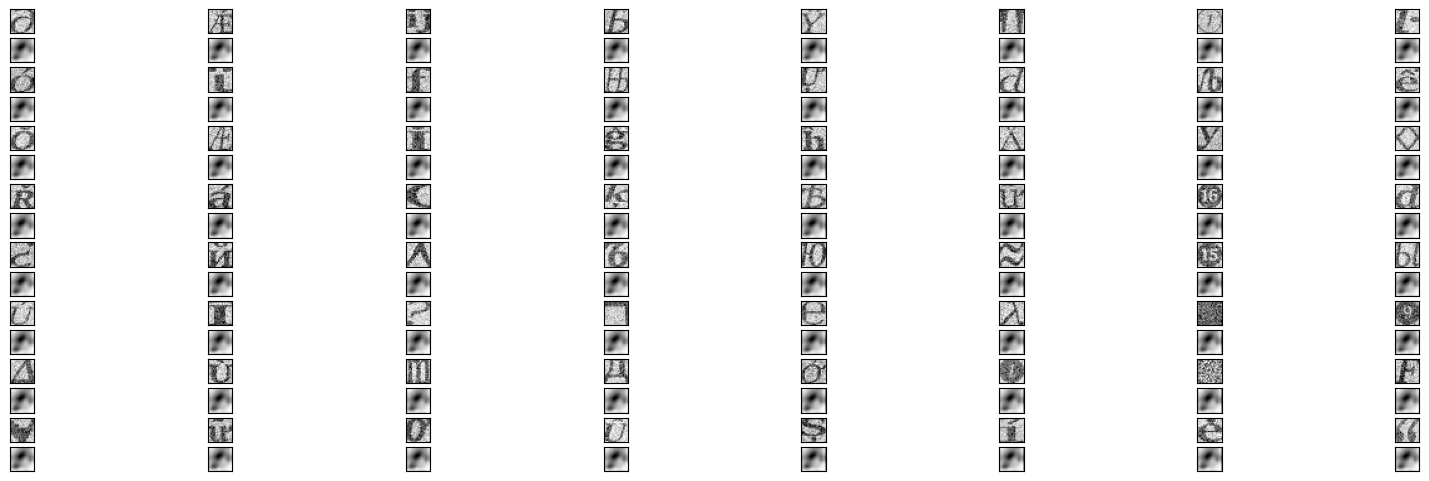

In [166]:
def drawComparisonsCNN(model):
    test_loader = torch.utils.data.DataLoader(xy_test_noise, batch_size=8, shuffle=True, num_workers=0)
    plt.figure(figsize=(20, 6))
    for i, batch in enumerate(test_loader):
        if i >= 8: break
        images = batch[0]
        images = images.reshape(-1, 1, 20, 20)
        with torch.no_grad():
            reconstructed = model(images.float())
            for j in range(len(images)):
                ax = plt.subplot(16, 8, i * 16 + j + 1)
                plt.imshow(images[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
                ax = plt.subplot(16, 8, i * 16 + j + 1 + 8)
                plt.imshow(reconstructed[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        
drawComparisonsCNN(cnnNet)